In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.applications.vgg16 import VGG16

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    #preprocessing_function=to_grayscale_then_rgb,
    validation_split=0.25)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Contrasted",
    target_size=(250, 250),
    batch_size=16,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    r"C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Contrasted", # same directory as training data
    target_size=(250, 250),
    batch_size=16,
    class_mode='binary',
    subset='validation')

img_size = (224, 224 , 3)

Found 411 images belonging to 2 classes.
Found 136 images belonging to 2 classes.


In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

In [ ]:
#Freeze weights 
for layer in base_model.layers[1:15]:
    layer.trainable = False


In [12]:

for i,layer in enumerate(base_model.layers):
    print(i,layer.name,layer.trainable)

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [13]:
model = tf.keras.Sequential([
    base_model,tf.keras.layers.Dropout(0.2)
])
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units= 128, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units= 1, activation = 'sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = opt, loss = 'binary_focal_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 17,926,209


In [14]:
history = model.fit(train_generator, validation_data=validation_generator, epochs = 8)

Epoch 1/8
26/26 [==============================] - 182s 7s/step - loss: 0.2626 - accuracy: 0.5426 - val_loss: 0.1531 - val_accuracy: 0.6691
Epoch 2/8
26/26 [==============================] - 174s 7s/step - loss: 0.1465 - accuracy: 0.7080 - val_loss: 0.1286 - val_accuracy: 0.7426
Epoch 3/8
26/26 [==============================] - 165s 6s/step - loss: 0.1474 - accuracy: 0.7080 - val_loss: 0.1741 - val_accuracy: 0.6618
Epoch 4/8
26/26 [==============================] - 165s 6s/step - loss: 0.1390 - accuracy: 0.7178 - val_loss: 0.1269 - val_accuracy: 0.7500
Epoch 5/8
26/26 [==============================] - 160s 6s/step - loss: 0.1496 - accuracy: 0.7324 - val_loss: 0.1646 - val_accuracy: 0.6103
Epoch 6/8
26/26 [==============================] - 161s 6s/step - loss: 0.1684 - accuracy: 0.5961 - val_loss: 0.1520 - val_accuracy: 0.7059
Epoch 7/8
26/26 [==============================] - 169s 6s/step - loss: 0.1487 - accuracy: 0.7105 - val_loss: 0.1432 - val_accuracy: 0.7206
Epoch 8/8
26/26 [===

In [15]:
##Confusion Matrix Generator and ROC Curve
y_pred_real = model.predict(validation_generator)
y_pred = [int(p >= 0.5) for p in y_pred_real] ##With sigmoid 1 neuron
##y_pred = np.argmax(Y_pred, axis=1) ##With softmax and 2 neurons 
y_true = validation_generator.classes
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
print(cm)

9/9 [==============================] - 13s 1s/step
[[69 13]
 [42 12]]


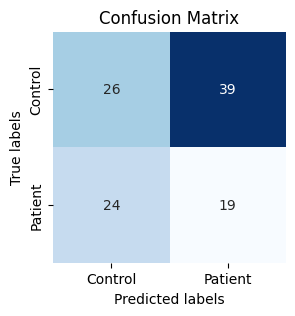

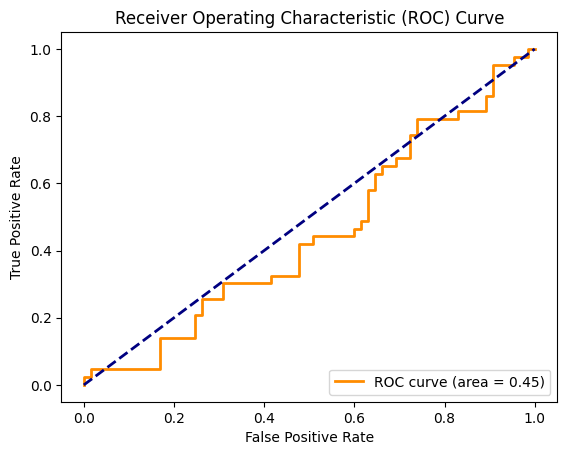

In [24]:
# Define the class labels
class_names = validation_generator.class_indices.keys()
import seaborn as sns
# Plot the confusion matrix as an image
fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# Calculate the ROC curve and AUC score, sklearn takes probabilities instead of classes
fpr, tpr, thresholds = roc_curve(y_true, y_pred_real)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()